### Option pricing with different volatilities
Motivation towards $\mathbb{R}^n \to \mathbb{R}^m$

In [1]:
from BS_Fun import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
k = np.arange(1,100,0.1)
sig = [0.5,1,2,3]
trial = BS_Options_Pricing_sigma(S=20,K=k,T=1,r=0.01,sigma=sig)
trial.make_calls()


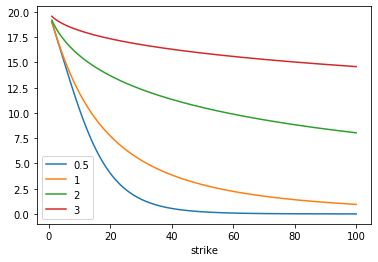

In [3]:
trial.calls.update({'strike':k})
df(trial.calls).plot('strike')

In [4]:
# k = np.arange(1,30,1)
# sig = np.arange(0.5,5,0.5)
# trial = BS_Options_Pricing_sigma(S=20,K=k,T=1,r=0,sigma=sig)
# trial.make_calls()

In [5]:
# trial.calls.update({'strike':k})
# df(trial.calls).plot('strike')

## Non-linear approximation: towards $\mathbb{R}^{16} \to \mathbb{R}$

In [6]:
from tf_Fun import *
initialisation_tf()

2.7.0


In [7]:
def generate_sample_no_noise(S=20,K=np.arange(5,21,1),
                             T=1,r=0,true_sigma=np.arange(0.1,5,0.01)):
    '''
    We receive data over different calls, and would like to recover sigma
    Assume that we have no noise in the data
    '''
    trial=BS_Options_Pricing_sigma(S,K,T,r,true_sigma)
    trial.make_calls()
#     data =df({'Strike price':K,
#     'Call price':trial.calls})
    data=df(trial.calls).transpose()
    data.reset_index(inplace=True)
    data.columns=['sig']+K.tolist()
    return data

In [8]:
data=generate_sample_no_noise()

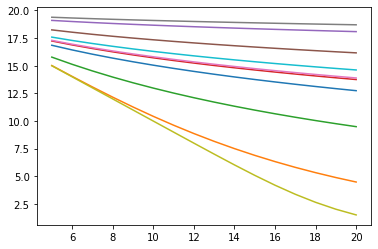

In [9]:
data.set_index('sig').iloc[nr.randint(500,size=10)].transpose().plot(legend=False)

In [10]:
y = data.pop('sig')
X = data
X_train, X_test, y_train, y_test = skms.train_test_split(
    X, y, test_size=0.33, random_state=0)

# y_train=y_train.to_numpy().reshape((X_train.shape[0],1))

In [11]:
feature_normaliser = layers.Normalization(input_shape=[16], axis=1,name='normaliser')
feature_normaliser.adapt(X_train)

In [12]:
lr=linear_regression_make(feature_normaliser)
history = lr.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=1,
    validation_data = (X_test,
                      y_test)
)
#Problems! Initialisation matters 

Model: "linear_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 16)                33        
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 50
Trainable params: 17
Non-trainable params: 33
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 0s 14ms/step - loss: 489440.5938 - val_loss: 77859552.0000
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 14287535865856.0000 - val_loss: 628473102073856.0000
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 104130462569363144704.0000 - val_loss: 11021418425483750539264.0000
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 

see https://keras.io/api/layers/initializers/ for instance

In [13]:
# lr.weights

### Observe the importance of zeroweights and / or SGD learning rate

In [14]:
lr0=linear_regression_make_zeroweights(feature_normaliser)
# lr.weights
lr0.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss='mean_squared_error')
history0 = lr0.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=0,
    validation_data = (X_test,
                      y_test)
)

Model: "linear_regression_zeroweights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 16)                33        
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 50
Trainable params: 17
Non-trainable params: 33
_________________________________________________________________


In [15]:
lr1=linear_regression_make(feature_normaliser)
lr1.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss='mean_squared_error'
)
history1 = lr1.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=0,
    validation_data = (X_test,
                      y_test)
)

Model: "linear_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 16)                33        
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 50
Trainable params: 17
Non-trainable params: 33
_________________________________________________________________


In [16]:
D0=df(history0.history)
D0.columns=['l0','val_l0']
D1=df(history1.history)
D1.columns=['l1','val_l1']

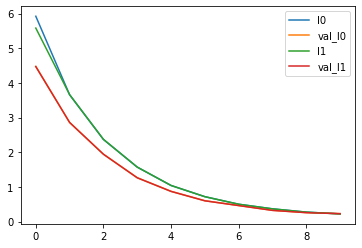

In [17]:
D0.join(D1).plot()

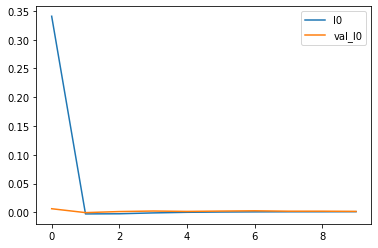

In [18]:
(D0-D1.values).plot()

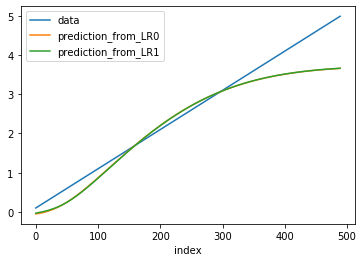

In [19]:
y_pred0=lr0.predict(X)
y_pred1=lr1.predict(X)

aligned_result=df(y).reset_index().join(df(y_pred0)).join(df(y_pred1),rsuffix='1').set_index('index')
# aligned_result.plot()
aligned_result.columns=['data','prediction_from_LR0','prediction_from_LR1']
aligned_result.sort_index().plot()

In [20]:
# y_pred=linear_regression.predict(X_test)
# aligned_result=df(y_test).reset_index().join(df(y_pred)).set_index('index')
# aligned_result.columns=['data','prediction']
# aligned_result.sort_index().plot()

In [21]:
Linear=linear_regression_make(feature_normaliser)
Linear.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss='mean_squared_error')

Model1 = keras.Sequential(name='One_layer_model')
Model1.add(feature_normaliser)
Model1.add(layers.Dense(16,activation='sigmoid',name='sigmoid'))
Model1.add(layers.Dense(1,name='dense_after_sigmoid'))
Model1.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

Model2 = keras.Sequential(name='Two_layers_model')
Model2.add(feature_normaliser)
Model2.add(layers.Dense(16,activation='sigmoid',name='sigmoid0'))
Model2.add(layers.Dense(8,name='linear_8X4'))
Model2.add(layers.Dense(4,activation='sigmoid',name='sigmoid1'))
Model2.add(layers.Dense(1,name='linear_8X1'))
Model2.summary()
Model2.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

history0 = Linear.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history1 = Model1.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history2 = Model2.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

Model: "linear_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 16)                33        
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 50
Trainable params: 17
Non-trainable params: 33
_________________________________________________________________
Model: "Two_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 16)                33        
                                                                 
 sigmoid0 (Dense)            (None, 16)                272       
                                                                 
 linear_8X4 (Dense)       

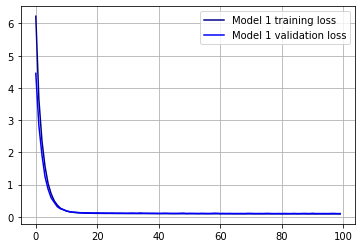

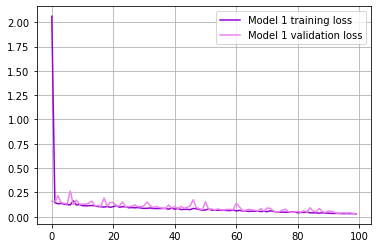

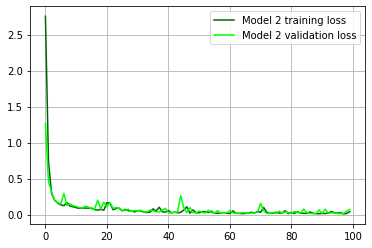

In [22]:
plt.figure()
plt.plot(history0.history['loss'], label='Model 1 training loss',color='darkblue')
plt.plot(history0.history['val_loss'], label='Model 1 validation loss',color='blue')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history1.history['loss'], label='Model 1 training loss',color='darkviolet')
plt.plot(history1.history['val_loss'], label='Model 1 validation loss',color='violet')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history2.history['loss'], label='Model 2 training loss',color='darkgreen')
plt.plot(history2.history['val_loss'], label='Model 2 validation loss',color='lime')
plt.legend()
plt.grid(True)
plt.show()

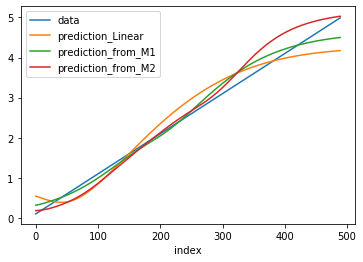

In [23]:
y_pred0=Linear.predict(X)
y_pred1=Model1.predict(X)
y_pred2=Model2.predict(X)

aligned_result=df(y).reset_index().join(df(y_pred0)).join(df(y_pred1),rsuffix='1').join(df(y_pred2),rsuffix='11').set_index('index')
# aligned_result.plot()
aligned_result.columns=['data','prediction_Linear','prediction_from_M1','prediction_from_M2']
aligned_result.sort_index().plot()

In [24]:
print('Linear model: %.3f' % Linear.evaluate(X_test, y_test,verbose=0))
print('Model 1: %.3f' % Model1.evaluate(X_test, y_test,verbose=0))
print('Model 2: %.3f' % Model2.evaluate(X_test, y_test,verbose=0))

Linear model: 0.103
Model 1: 0.032
Model 2: 0.071


In [25]:
history0 = Linear.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history1 = Model1.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history2 = Model2.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_data = (X_test,
                      y_test))

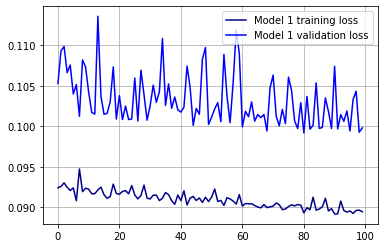

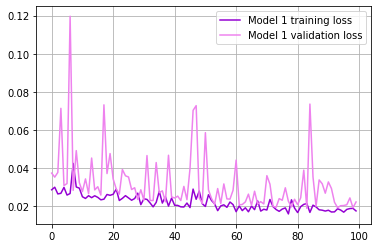

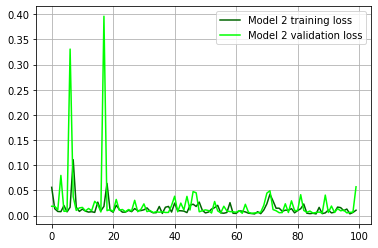

In [26]:
plt.figure()
plt.plot(history0.history['loss'], label='Model 1 training loss',color='darkblue')
plt.plot(history0.history['val_loss'], label='Model 1 validation loss',color='blue')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history1.history['loss'], label='Model 1 training loss',color='darkviolet')
plt.plot(history1.history['val_loss'], label='Model 1 validation loss',color='violet')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history2.history['loss'], label='Model 2 training loss',color='darkgreen')
plt.plot(history2.history['val_loss'], label='Model 2 validation loss',color='lime')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print('After another 100 steps:')
print('Linear model: %.3f' % Linear.evaluate(X_test, y_test,verbose=0))
print('Model 1: %.3f' % Model1.evaluate(X_test, y_test,verbose=0))
print('Model 2: %.3f' % Model2.evaluate(X_test, y_test,verbose=0))

After another 100 steps:
Linear model: 0.100
Model 1: 0.022
Model 2: 0.057


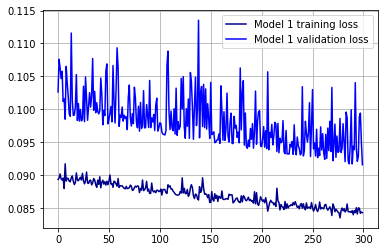

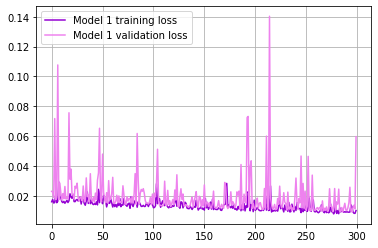

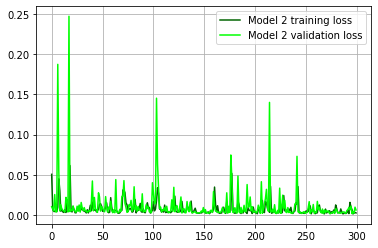

After another 300 steps:
Linear model: 0.092
Model 1: 0.060
Model 2: 0.006


In [28]:
history0 = Linear.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history1 = Model1.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_data = (X_test,
                      y_test))

history2 = Model2.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_data = (X_test,
                      y_test))

plt.figure()
plt.plot(history0.history['loss'], label='Model 1 training loss',color='darkblue')
plt.plot(history0.history['val_loss'], label='Model 1 validation loss',color='blue')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history1.history['loss'], label='Model 1 training loss',color='darkviolet')
plt.plot(history1.history['val_loss'], label='Model 1 validation loss',color='violet')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history2.history['loss'], label='Model 2 training loss',color='darkgreen')
plt.plot(history2.history['val_loss'], label='Model 2 validation loss',color='lime')
plt.legend()
plt.grid(True)
plt.show()

print('After another 300 steps:')
print('Linear model: %.3f' % Linear.evaluate(X_test, y_test,verbose=0))
print('Model 1: %.3f' % Model1.evaluate(X_test, y_test,verbose=0))
print('Model 2: %.3f' % Model2.evaluate(X_test, y_test,verbose=0))

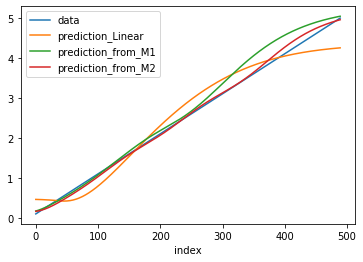

In [29]:
y_pred0=Linear.predict(X)
y_pred1=Model1.predict(X)
y_pred2=Model2.predict(X)

aligned_result=df(y).reset_index().join(df(y_pred0)).join(df(y_pred1),rsuffix='1').join(df(y_pred2),rsuffix='11').set_index('index')
# aligned_result.plot()
aligned_result.columns=['data','prediction_Linear','prediction_from_M1','prediction_from_M2']
aligned_result.sort_index().plot()